In [14]:
import pandas as pd
import logging
import json
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt 
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import HashingVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor

INFO:root:Loading training/test data


unique publishers: 120
Missing train data: ENTRYTYPE        0
title            0
editor       64438
year             0
publisher     8201
author        2399
abstract     33531
dtype: int64
###
Missing test data: ENTRYTYPE        0
title            0
editor       21479
publisher     2813
author         831
abstract     11278
dtype: int64
moving on creating new variables


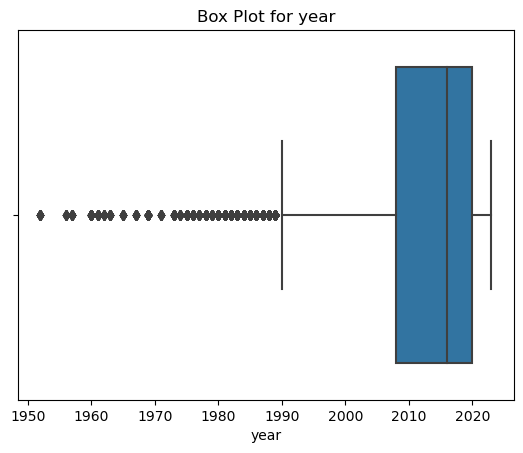

In [15]:
#--- Preprocessing of data ---

logging.getLogger().setLevel(logging.INFO)
logging.info("Loading training/test data")
train = pd.DataFrame.from_records(json.load(open('train.json')))
test = pd.DataFrame.from_records(json.load(open('test.json')))
# Function to handle joining lists or leave strings unchanged
def join_or_leave(x):
    if isinstance(x, list):
        return ', '.join(x)
    else:
        return x

# Transform columns that are lists to strings
train['author'] = train['author'].apply(join_or_leave)
train['editor'] = train['editor'].apply(join_or_leave)
#train['year'] = pd.to_numeric(train['year'], errors="coerce")
#train.year = pd.to_numeric(train.year, errors="coerce")
test['author'] = test['author'].apply(join_or_leave)
test['editor'] = test['editor'].apply(join_or_leave)   

unique_publishers = train['publisher'].nunique()
print(f"unique publishers: {unique_publishers}")
print("Missing train data:", train.isna().sum())
print("###")
print("Missing test data:", test.isna().sum())
print("moving on creating new variables")


# Convert 'year' to numeric type and create boxplot
train['year'] = pd.to_numeric(train['year'], errors='coerce')
#convert year on train into integers
train['year'] = train['year'].astype('Int64')

sns.boxplot(x=train["year"])
plt.title(f'Box Plot for {"year"}')
plt.show()

# Remove outliers based on boxplot whiskers 
q1 = train['year'].quantile(0.25)
q3 = train['year'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

#update train dataset with not having the outliers and use boxplot again (overfits our model)
#train = train[(train['year'] >= lower_bound) & (train['year'] <= upper_bound)]

In [16]:
# --- Imputing Missing Data ---

train = train.fillna("")
test = test.fillna("")

imp = SimpleImputer(missing_values="", strategy="constant")
imputer_train = imp.fit(train)
train = pd.DataFrame(imputer_train.fit_transform(train), columns=train.columns)
imputer_test = imp.fit(test)
test = pd.DataFrame(imputer_test.transform(test), columns=test.columns)
print("Imputing missing data works")
print("Missing train data:", train.isna().sum())
print("###")
print("Missing test data:", test.isna().sum())

train.drop_duplicates(["title"], inplace=True)

Imputing missing data works
Missing train data: ENTRYTYPE    0
title        0
editor       0
year         0
publisher    0
author       0
abstract     0
dtype: int64
###
Missing test data: ENTRYTYPE    0
title        0
editor       0
publisher    0
author       0
abstract     0
dtype: int64


In [17]:
# --- Spliting data, Encoding, Hyperparameter tuning ---

logging.info("Splitting validation")
train, val = train_test_split(train, stratify=train['year'], random_state=123, test_size=0.2)

featurizer = ColumnTransformer(
    transformers=[("title", HashingVectorizer(ngram_range=(1,2)), "title"), 
        ("publisher", HashingVectorizer(ngram_range=(1,2)), "publisher"), 
        ("ENTRYTYPE",HashingVectorizer(ngram_range=(1,1)), "ENTRYTYPE"), 
        ("author", HashingVectorizer(ngram_range=(1,2)), "author"), 
        ("abstract",HashingVectorizer(ngram_range=(1,1)), "abstract") 
        ],
remainder='drop')

print(featurizer.fit_transform(train).shape) #(52251, 5242880)

INFO:root:Splitting validation


(52251, 5242880)


In [18]:
# creating models
ridge = make_pipeline(featurizer, Ridge())  

logging.info("Fitting models")
ridge.fit(train.drop('year', axis=1), train['year'].values)


INFO:root:Fitting models


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('title',
                                                  HashingVectorizer(ngram_range=(1,
                                                                                 2)),
                                                  'title'),
                                                 ('publisher',
                                                  HashingVectorizer(ngram_range=(1,
                                                                                 2)),
                                                  'publisher'),
                                                 ('ENTRYTYPE',
                                                  HashingVectorizer(),
                                                  'ENTRYTYPE'),
                                                 ('author',
                                                  HashingVectorizer(ngram_range=(1,
                                                                                 2)),
                                                  'author'),
                                                 ('abstract',
                                                  HashingVectorizer(),
                                                  'abstract')])),
                ('ridge', Ridge())])

In [19]:
# --- Evaluating ---

pred_ridge = ridge.predict(val.drop('year', axis=1))
pred_ridge_clipped = np.clip(pred_ridge, None, 2023)
err_ridge = mean_absolute_error(val['year'].values, pred_ridge_clipped)
logging.info(f"Ridge regress MAE with clipping: {err_ridge}")

# Combining train and validation sets
combined_train = pd.concat([train, val], axis=0)

#re-fitting the best model
ridge = make_pipeline(featurizer, Ridge())
ridge.fit(combined_train.drop('year', axis=1), combined_train['year'].values)

# logging.info(f"Predicting on test")
pred = ridge.predict(test)
pred_clipped = np.clip(pred, None, 2023)
pred = pred_clipped.round().astype(int)
test['year'] = pred
logging.info("Writing prediction file")
test.to_json("predicted.json", orient='records', indent=2)

INFO:root:Ridge regress MAE with clipping: 3.2661573227328735
INFO:root:Writing prediction file
